# Creating Value Maps

Value mapping is a great way to quickly and concisely display spatial result.  In this tutorial, we will learn how to initialize a map centered on the Unitied States, and display some data values by division. We will also learn how to check whether a point (a weather station location in this case) is within a particular division.

## Initialize a basemap

See https://basemaptutorial.readthedocs.org/en/latest/# for further details.

### Import modules

Basemap is essentially a GIS extension for Python, and is incredibly flexible. It can read shapefiles, and plot 'polygons' using collections of patches - essentially bounded map regions (could be a state, county, town, national forest, etc). First we import all the necessary modules.

In [1]:
%matplotlib inline
from matplotlib import cm, colors, rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from os import environ as EV
from pprint import pprint
import numpy as np
#rcParams['image.cmap'] = 'magma_r'

### Make a map object

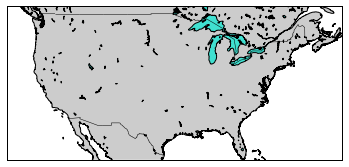

In [2]:
def US_basemap():
    #_initialize figure and axes objects
    fig, ax = plt.subplots(1, 1)

    #_initizlize a basemap object
    #_there are many more options - see the readthedocs for a basic
    m = Basemap(  ax = ax, projection = 'merc', 
                  llcrnrlon=-130, llcrnrlat = 25,
                  urcrnrlon = -60, urcrnrlat=50, 
                  resolution = 'i')
    m.drawmapboundary()
    m.drawcountries()
    m.drawcoastlines()
    m.fillcontinents(lake_color = 'turquoise');
    return fig, ax, m
fig, ax, m = US_basemap()

## Working with shapefiles
This section will show how to read a shapefile and examine its attributes. We will also look at the differences between shapes and polygons, and the implications.

### Read the shapefile
We know that there are 344 climate divisions in CONUS, so we should expect that many shapes to be in the shapefile.

Number of distinct shapes is 344


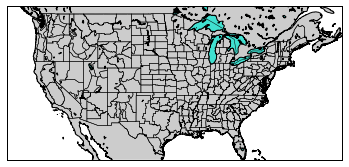

In [3]:
#_set the path to the shapefile
fp = EV['SHPFILES'] + \
        '/CONUS_CLIMATE_DIVISIONS/GIS_OFFICIAL_CLIM_DIVISIONS'

#_read the shapefile into the map
#_the name argument stores all the polygons in a basemap
#_attribute with the string you supply.
def add_shapefile(fp):
    #_initilize the map with our US_basemap function from above.
    fig, ax, m = US_basemap()
    output = m.readshapefile(shapefile = fp, name = 'climdivs')
    
    #_lets print the number of distinct shapes. type 
    #_help(m.readshapefile) to see what the output is
    
    print('Number of distinct shapes is %i' % output[0])
    
    return fig, ax, m

fig, ax, m = add_shapefile(fp)


### Examine individual shapefile polygons
When you read the shapefile into the basemap object, it stores the polygons in the .name attribute (m.climdivs in this example), and information about the polygon in the .name_info attribute (m.climdivs_info).

Lets see how many polygons are needed to make up the shapes (often times it can take many polygons to make a shape).

In [4]:
print(len(m.climdivs))

1636


Yep, turns out to make 344 climate divisions, we need 1636 polygons.

Because every polygon has a paired 'info' attribute, there will be 1636 info attributes. Lets see what 'info' contains for one of them.

In [5]:
pprint(m.climdivs_info[0])

{'CD_2DIG': '05',
 'CD_NEW': 5,
 'CLIMDIV': 2905,
 'FIPS_CD': '3505',
 'NAME': 'CENTRAL VALLEY',
 'NCDC_GEO_I': 1.0,
 'OBJECTID': 91,
 'RINGNUM': 1,
 'SHAPENUM': 1,
 'SHAPE_AREA': '0.00000000000e+000',
 'SHAPE_LEN': '0.00000000000e+000',
 'STATE': 'New Mexico',
 'STATE_CODE': 29,
 'STATE_FIPS': '35',
 'ST_ABBRV': 'NM'}


So info is a dictionary, containing a bunch of information. For our purposes here, we are interested in the 'CLIMDIV' entry - there should be 344 unique climdiv entries (one for each climate divison). We can check this using a list comprehension combined with the 'set' function. The list comprehension will give us the 'CLIMDIV' code for each polygon - the set function will create a new list of unique entries.

In [6]:
div_codes = [info['CLIMDIV'] for info in m.climdivs_info]
print(len(div_codes))

1636


In [7]:
unique_div_codes = set(div_codes)
print(len(unique_div_codes))


344


Great. We have 344 unique shapes, and 344 unique climate division codes, and it takes 1636 polygons to make them all. If we wanted, we could check how many polygons it takes to make each division.

In [8]:
#_convert all div codes from list to array for evaluation
div_codes = np.array(div_codes)

#_initialize dictionary to hold results
results = {}

for div_code in unique_div_codes:
    n_poly = sum(div_codes==div_code)
    results[str(div_code)] = n_poly

#_print a few examples
for key in ['101', '801', '1001']:
    print('Division code %s needs %i polygon(s)'%(key, results[key]))

Division code 101 needs 1 polygon(s)
Division code 801 needs 7 polygon(s)
Division code 1001 needs 1 polygon(s)


### Plot values on the map
Here we're interested in seeing how some value varies by climate division. 

The variable alldivDF is a data frame holding the seasonal total rainfall for each climate division by year.

In [9]:
from climdiv_data import create_kwgroups, load_climdiv_dataframes
kwgroups = create_kwgroups()
alldivDF, _, _ = load_climdiv_dataframes(**kwgroups['climdiv'])

So, lets plot the mean of the data on the map. First we need to define a colormapper that will scale our data appropriately, then we define a function that takes a pandas series as input.

In [10]:
def colorMapper(data):
    #_this helper function returns mapper that will normalize
    #_the colors in your dataset for plotting
    
    minima = min(data.values)
    maxima = max(data.values)
    norm = mpl.colors.Normalize(vmin = minima,
                                vmax = maxima,
                                clip = True)
    mapper = mpl.cm.ScalarMappable(norm = norm)
    return norm, mapper

In [11]:
def valueMap(data, fp):
    from division_data import reverseStates, importStates
    fig, ax, m = add_shapefile(fp)
    norm, mapper = colorMapper(data)
    
    #_importStates returns a dictionary where keys are states and
    #_values are the state code; reverseStates switches keys/values
    codes = reverseStates(importStates())
    
    #_the names in data.index are in the form 'statename-yy'
    #_where yy is the within state division code. However, we
    #_can see above that we need to change this to be 'yyxx' to
    #_match the shapefile info['CLIMDIV'], where yy is the state code
    
    #_we want to loop through every climate division, assign a color
    #_based on the value of data, and then plot it on the map
    for name in data.index:
        #_we use the codes dictionary to generate state codes from
        #_state names, and then add the in-state code
        divcode = codes[name[:-3]] + name[-2:]
        
        #_get the data value
        data_value = data[name]
        color = mapper.to_rgba(data_value)
        
        #_initizlize a list that can contain multiple polygons;
        #_remember, some shapes are made of several polygons
        patches = []
        
        #_loop through all the polygons and info
        for info, polygon in zip(m.climdivs_info, m.climdivs):
            if info['CLIMDIV'] == int(divcode):
                poly = mpl.patches.Polygon(np.array(polygon))
                patches.append(poly)
                
        #_add all patches that make the shape to the axis as a 
        #_collection with the same color 
        ax.add_collection(mpl.collections.PatchCollection(patches,
                            facecolor = color, edgecolor = 'k',
                            linewidths = 1., zorder = 2))
    
    #_add a colorbar
    c_ax = fig.add_axes([.925, .3, .025, .4])
    cb = mpl.colorbar.ColorbarBase(c_ax, norm = norm)
    c_ax.set_title('Inches', fontsize = 8)
    
    return fig, ax, m
                

Okay lets finally call the functions, setting the input data to 

In [12]:
data = alldivDF.mean()
print(data.head())

Alabama-01    19.345083
Alabama-02    19.621417
Alabama-03    19.545667
Alabama-04    19.210333
Alabama-05    19.062750
dtype: float64


Can see that the names of the rows (the index) are the division names, and they each have one value associated with them. You could put in any pandas Series with the same index (i.e. the data values can change, could be mean, std, number of events, etc.

Number of distinct shapes is 344


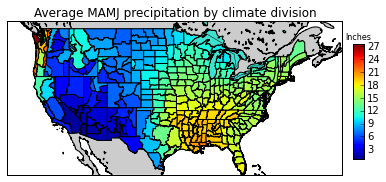

In [13]:
fig, ax, m = valueMap(data, fp)
ax.set_title('Average MAMJ precipitation by climate division');

Now you should be able to substitute any set of values into data and use these functions to generate value maps.